In [2]:
!pip install catboost

In [3]:
!pip install category_encoders

# 1. Поиск, выбор и импорт набора данных для построения моделей машинного обучения

В качестве набора данных мы будем использовать набор данных по вычислению арендной платы за дома в Бразилии - https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv

Задача прогнозирований стоимости дома является актуальной для людей, занимающихся продажей домов: они смогут предсказать стоимость здания в зависимости от других входных парметров.

Датасет состоит из одного файла: export.csv

Файл содержит следующие колонки:

1. city - город	
1. area	- область
1. rooms	- количество комнат	
1. bathroom - количество ванных комнат
1. parking spaces - количество парковачных мест	
1. floor	-количество дверей
1. animal	- разрешение на животных
1. furniture	- наличие мебели
1. hoa	 - налог на товарищество собственников жилья в долларах
1. rent amount - арендная плата в долларах
1. property tax - налог на недвижимость в долларах
1. fire insurance - страхование от пожара в долларах
1. total - суммарная плата за дом в долларах

В рассматриваемом примере будем решать задачу регрессии. 
В качестве целевого признака будем использовать "total".

## Импорт библиотек

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import  LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 


%matplotlib inline

sns.set(style="whitegrid")

## Импорт датасета

Импорт датасета производится из Google Диск

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv("/content/drive/My Drive/datasets_554905_1035602_houses_to_rent_v2.csv")

# 2. Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [6]:
print('размер датасета : ', df.shape)

размер датасета :  (10692, 13)


In [7]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


Для удобства уберем пробелы в названиях столбцов

In [8]:
col_names = ['City', 'Area', 'Rooms', 'Bathroom', 'Parking_spaces', 'Floor', 'Animal', 'Furniture',
             'Hoa', 'Rent_amount','Property_tax' ,'Fire_insurance' ,'Total']
df.columns = col_names
df.columns

Index(['City', 'Area', 'Rooms', 'Bathroom', 'Parking_spaces', 'Floor',
       'Animal', 'Furniture', 'Hoa', 'Rent_amount', 'Property_tax',
       'Fire_insurance', 'Total'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   City            10692 non-null  object
 1   Area            10692 non-null  int64 
 2   Rooms           10692 non-null  int64 
 3   Bathroom        10692 non-null  int64 
 4   Parking_spaces  10692 non-null  int64 
 5   Floor           10692 non-null  object
 6   Animal          10692 non-null  object
 7   Furniture       10692 non-null  object
 8   Hoa             10692 non-null  int64 
 9   Rent_amount     10692 non-null  int64 
 10  Property_tax    10692 non-null  int64 
 11  Fire_insurance  10692 non-null  int64 
 12  Total           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
City,10692,5,São Paulo,5887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,10692,NaN,NaN,NaN,149.218,537.017,11,56,90,182,46335
Rooms,10692,NaN,NaN,NaN,2.50608,1.17127,1,2,2,3,13
Bathroom,10692,NaN,NaN,NaN,2.23681,1.4072,1,1,2,3,10
Parking_spaces,10692,NaN,NaN,NaN,1.60915,1.58952,0,0,1,2,12
Floor,10692,35,-,2461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Animal,10692,2,acept,8316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Furniture,10692,2,not furnished,8086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hoa,10692,NaN,NaN,NaN,1174.02,15592.3,0,170,560,1237.5,1.117e+06
Rent_amount,10692,NaN,NaN,NaN,3896.25,3408.55,450,1530,2661,5000,45000


In [11]:
df.isnull().sum()

City              0
Area              0
Rooms             0
Bathroom          0
Parking_spaces    0
Floor             0
Animal            0
Furniture         0
Hoa               0
Rent_amount       0
Property_tax      0
Fire_insurance    0
Total             0
dtype: int64

Построим некоторые графики для понимания структуры данных.

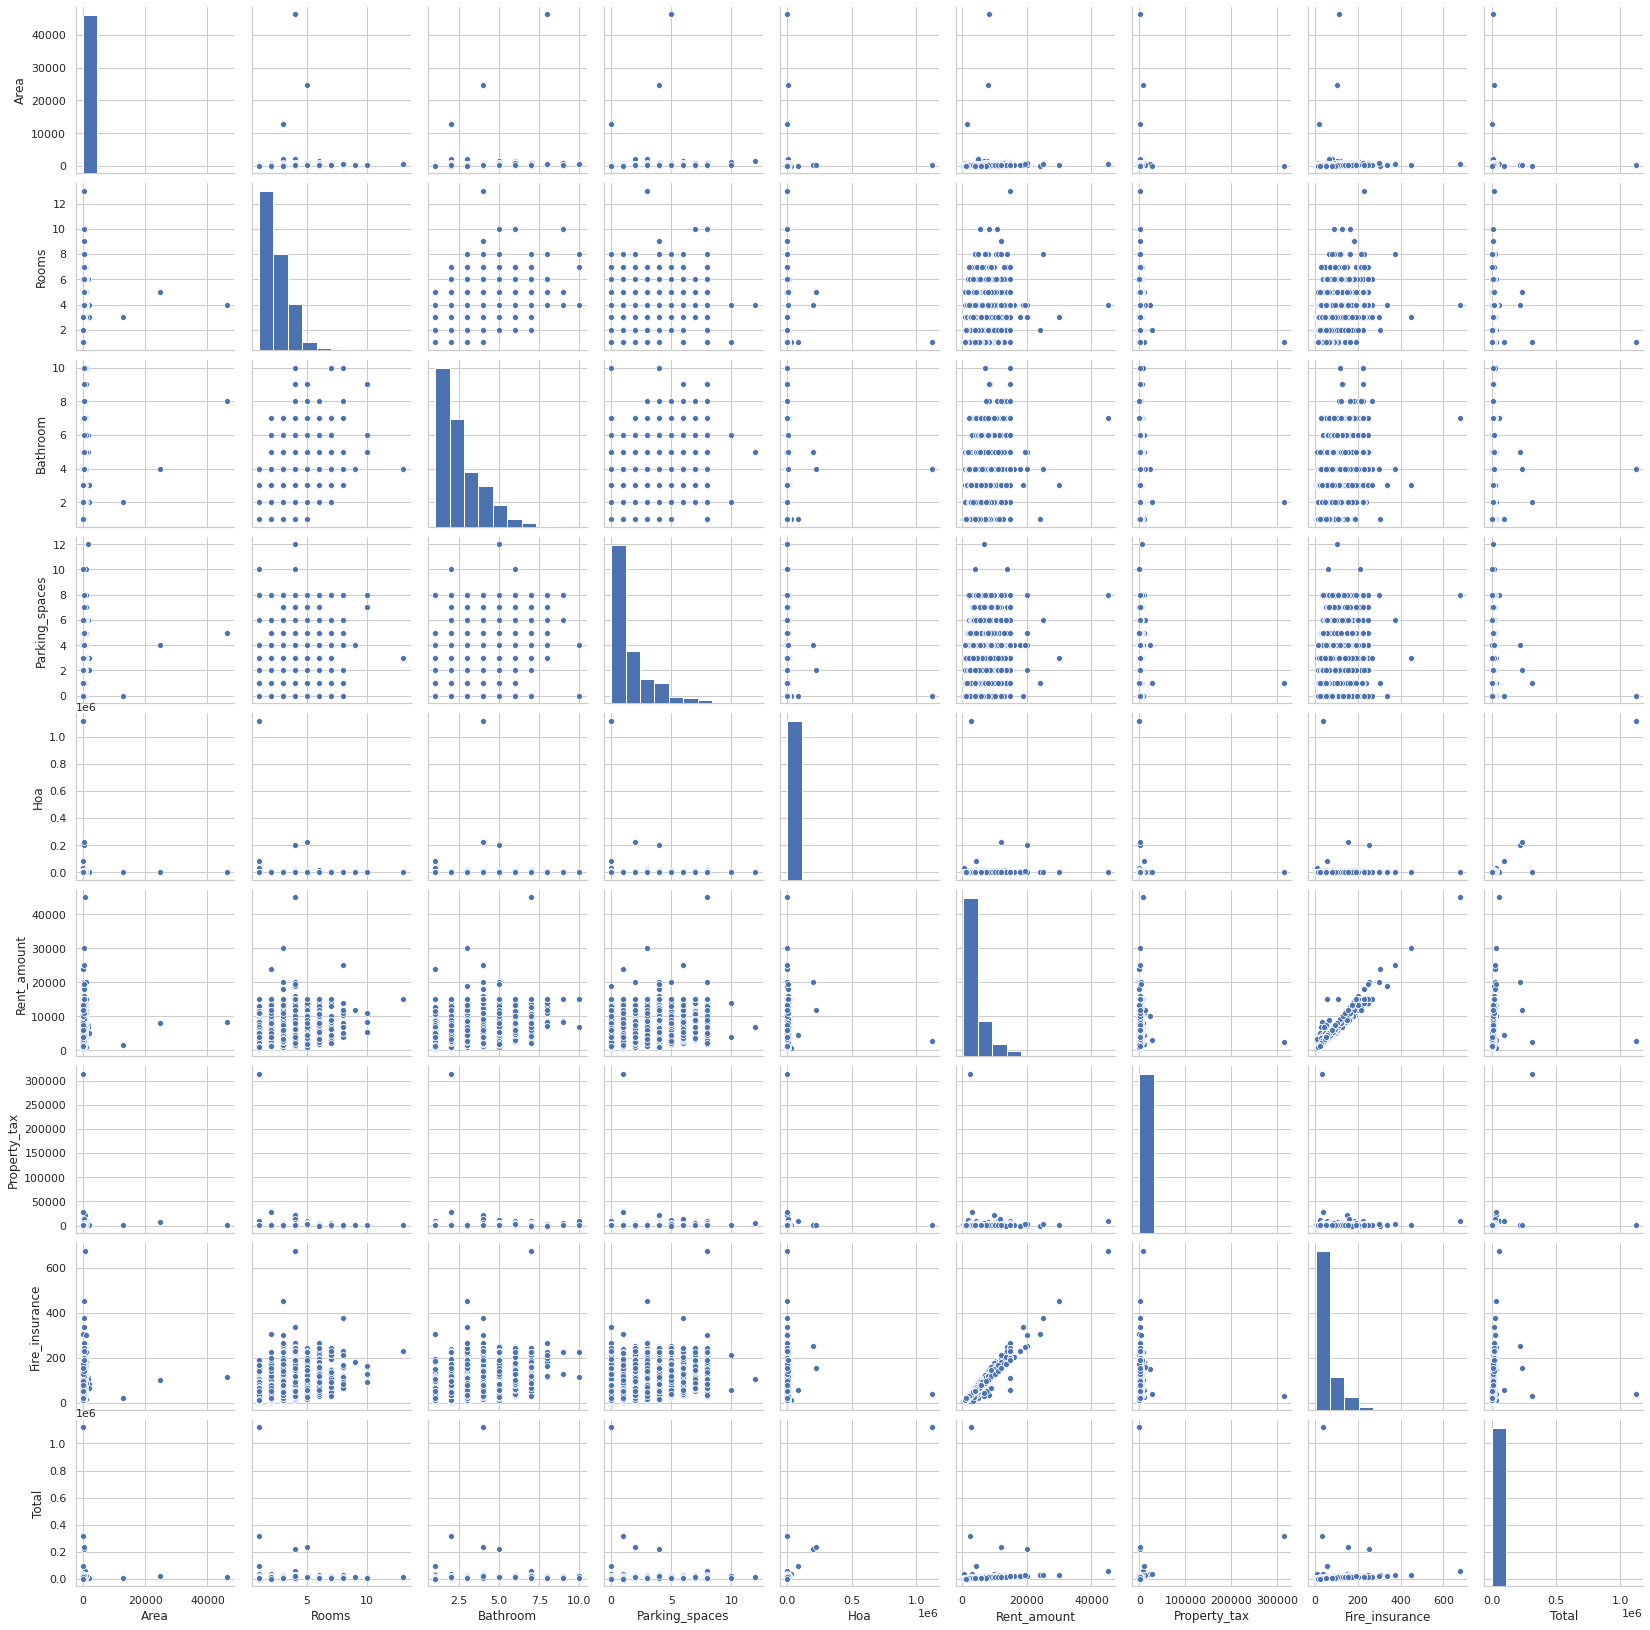

In [12]:
sns.pairplot(df)

## Исследование переменных

###Исследование категориальных переменных

In [13]:
categorical = [var for var in df.columns if df[var].dtype=='O']
df[categorical].head()

,City,Floor,Animal,Furniture
0,São Paulo,7,acept,furnished
1,São Paulo,20,acept,not furnished
2,Porto Alegre,6,acept,not furnished
3,Porto Alegre,2,acept,not furnished
4,São Paulo,1,not acept,not furnished


In [14]:
for var in categorical:
     print(df[var].value_counts()/np.float(len(df)))

São Paulo         0.550599
Rio de Janeiro    0.140385
Belo Horizonte    0.117658
Porto Alegre      0.111579
Campinas          0.079779
Name: City, dtype: float64
-      0.230172
1      0.101104
2      0.092125
3      0.087074
4      0.069959
5      0.056117
6      0.050412
7      0.046483
8      0.045829
9      0.034512
10     0.033389
11     0.028339
12     0.024037
13     0.018706
14     0.015900
15     0.013749
16     0.010195
17     0.008979
18     0.007015
19     0.004957
20     0.004115
21     0.003928
23     0.002338
25     0.002338
22     0.002245
26     0.001871
24     0.001777
27     0.000748
28     0.000561
29     0.000468
32     0.000187
46     0.000094
51     0.000094
301    0.000094
35     0.000094
Name: Floor, dtype: float64
acept        0.777778
not acept    0.222222
Name: Animal, dtype: float64
not furnished    0.756266
furnished        0.243734
Name: Furniture, dtype: float64


Уберем столбец с пропусками, отвечающий за количество дверей в доме.

In [0]:
del df['Floor']

In [16]:
df.columns

Index(['City', 'Area', 'Rooms', 'Bathroom', 'Parking_spaces', 'Animal',
       'Furniture', 'Hoa', 'Rent_amount', 'Property_tax', 'Fire_insurance',
       'Total'],
      dtype='object')

### Исследование численных переменных

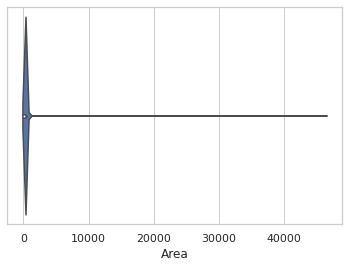

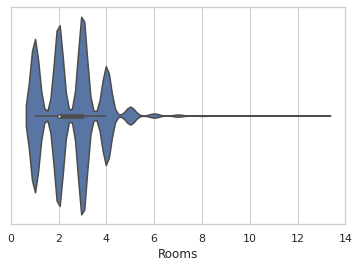

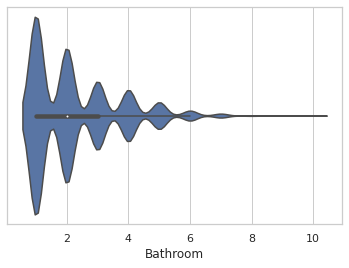

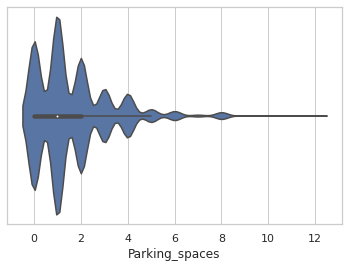

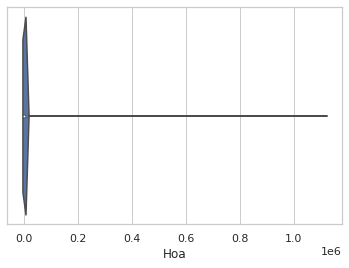

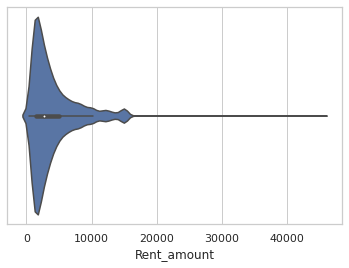

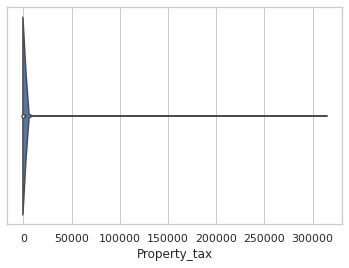

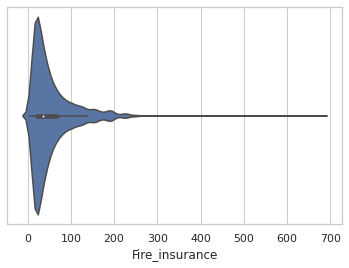

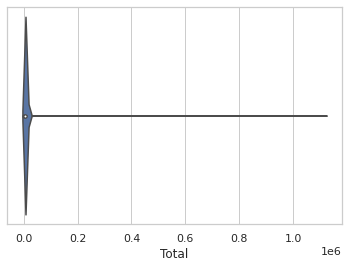

In [17]:
for col in ['Area', 'Rooms', 'Bathroom', 'Parking_spaces', 'Hoa', 'Rent_amount','Property_tax' ,'Fire_insurance' ,'Total']:
    sns.violinplot(x=df[col])
    plt.show()

### Исследование целевой переменной 

In [18]:
df['Total'].unique()

array([ 5618,  7973,  3841, ...,  3395,  4695, 19260])

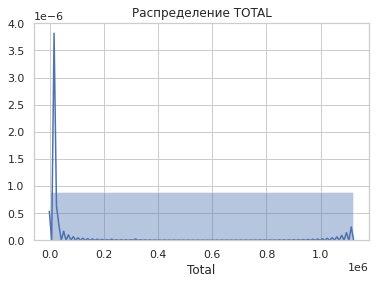

In [19]:
f, ax = plt.subplots()
x = df['Total']
ax = sns.distplot(x,bins=1)
ax.set_title("Распределение TOTAL")
plt.show()

In [20]:
df.corr().style.format("{:.4}").background_gradient(axis=1)

,Area,Rooms,Bathroom,Parking_spaces,Hoa,Rent_amount,Property_tax,Fire_insurance,Total
Area,1.0,0.1938,0.2268,0.194,0.00689,0.1807,0.03906,0.1881,0.0518
Rooms,0.1938,1.0,0.7338,0.6175,0.007139,0.5418,0.07525,0.5651,0.1346
Bathroom,0.2268,0.7338,1.0,0.6974,0.05027,0.6685,0.1093,0.6764,0.2083
Parking_spaces,0.194,0.6175,0.6974,1.0,0.009321,0.5784,0.09838,0.5973,0.1487
Hoa,0.00689,0.007139,0.05027,0.009321,1.0,0.03649,0.007627,0.02953,0.955
Rent_amount,0.1807,0.5418,0.6685,0.5784,0.03649,1.0,0.1079,0.9873,0.2645
Property_tax,0.03906,0.07525,0.1093,0.09838,0.007627,0.1079,1.0,0.1057,0.2183
Fire_insurance,0.1881,0.5651,0.6764,0.5973,0.02953,0.9873,0.1057,1.0,0.2549
Total,0.0518,0.1346,0.2083,0.1487,0.955,0.2645,0.2183,0.2549,1.0


# 3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. 

In [21]:
df.dtypes

City              object
Area               int64
Rooms              int64
Bathroom           int64
Parking_spaces     int64
Animal            object
Furniture         object
Hoa                int64
Rent_amount        int64
Property_tax       int64
Fire_insurance     int64
Total              int64
dtype: object

Для построения моделей будем использовать все признаки.
Категориальные признаки присутствуют: City, Animal, Furniture. 
Требуется их кодирование.

## Шифрование категориальных значений

In [22]:
categorical = [col for col in df.columns if df[col].dtypes == 'O']
categorical

['City', 'Animal', 'Furniture']

In [23]:
df[categorical].head()

,City,Animal,Furniture
0,São Paulo,acept,furnished
1,São Paulo,acept,not furnished
2,Porto Alegre,acept,not furnished
3,Porto Alegre,acept,not furnished
4,São Paulo,not acept,not furnished


Посмотрим какие уникальные значения имеют каждый из категориальных столбцов

In [24]:
df['City'].unique()

array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
       'Belo Horizonte'], dtype=object)

In [25]:
df['Animal'].unique()

array(['acept', 'not acept'], dtype=object)

In [26]:
df['Furniture'].unique()

array(['furnished', 'not furnished'], dtype=object)

Будем использовать label encoding - кодирование категорий целочисленными значениями

In [0]:
le = LabelEncoder()
df[categorical] = df[categorical].apply(lambda col: le.fit_transform(col))

In [29]:
df.head()

,City,Area,Rooms,Bathroom,Parking_spaces,Animal,Furniture,Hoa,Rent_amount,Property_tax,Fire_insurance,Total
0,4,70,2,1,1,0,0,2065,3300,211,42,5618
1,4,320,4,4,0,0,1,1200,4960,1750,63,7973
2,2,80,1,1,1,0,1,1000,2800,0,41,3841
3,2,51,2,1,0,0,1,270,1112,22,17,1421
4,4,25,1,1,0,1,1,0,800,25,11,836


Посмотрим какие уникальные значения имеют каждый из закодированных категориальных столбцов

In [30]:
df['City'].unique()

array([4, 2, 3, 1, 0])

In [31]:
df['Animal'].unique()

array([0, 1])

In [32]:
df['Furniture'].unique()

array([0, 1])

## Масштабирование

Применим MinMax масштабирование:

![alt text](https://sun9-9.userapi.com/rvklZr6AZ9m-HZqejnufAuSrUFRVqUM6pU4Hag/5GqfD6cX6lQ.jpg)

В этом случае значения будут лежать в диапазоне от 0 до 1.







In [0]:
scale_cols = [
 'City',
 'Area',
 'Rooms',
 'Bathroom',
 'Parking_spaces',
 'Animal',
 'Furniture',
 'Hoa',
 'Rent_amount',
 'Property_tax',
 'Fire_insurance']

In [0]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(df[scale_cols])

In [0]:
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    df[new_col_name] = sc1_data[:,i]

In [36]:
df.head()

,City,Area,Rooms,Bathroom,Parking_spaces,Animal,Furniture,Hoa,Rent_amount,Property_tax,Fire_insurance,Total,City_scaled,Area_scaled,Rooms_scaled,Bathroom_scaled,Parking_spaces_scaled,Animal_scaled,Furniture_scaled,Hoa_scaled,Rent_amount_scaled,Property_tax_scaled,Fire_insurance_scaled
0,4,70,2,1,1,0,0,2065,3300,211,42,5618,1.0,0.001274,0.083333,0.000000,0.083333,0.0,0.0,0.001849,0.063973,0.000673,0.057864
1,4,320,4,4,0,0,1,1200,4960,1750,63,7973,1.0,0.006670,0.250000,0.333333,0.000000,0.0,1.0,0.001074,0.101235,0.005579,0.089021
2,2,80,1,1,1,0,1,1000,2800,0,41,3841,0.5,0.001490,0.000000,0.000000,0.083333,0.0,1.0,0.000895,0.052750,0.000000,0.056380
3,2,51,2,1,0,0,1,270,1112,22,17,1421,0.5,0.000863,0.083333,0.000000,0.000000,0.0,1.0,0.000242,0.014860,0.000070,0.020772
4,4,25,1,1,0,1,1,0,800,25,11,836,1.0,0.000302,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.007856,0.000080,0.011869


Проверим, что масштабирование не повлияло на распределение данных

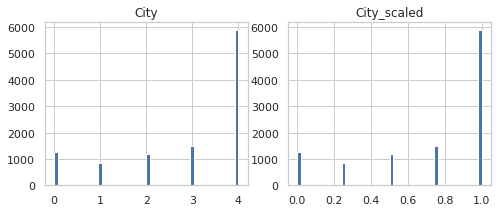

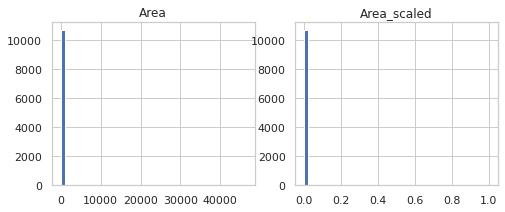

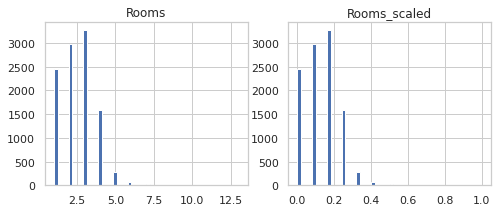

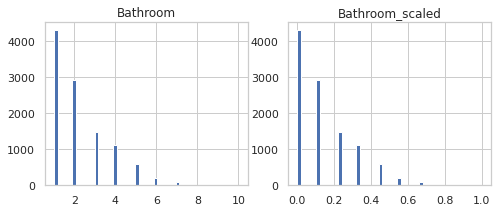

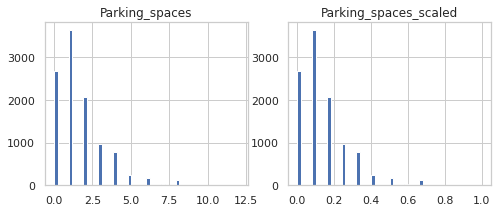

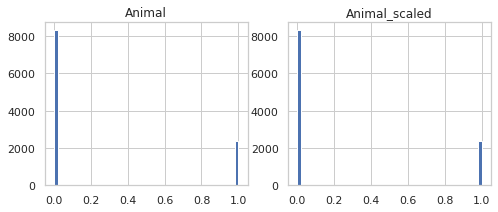

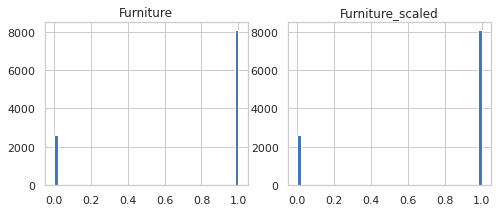

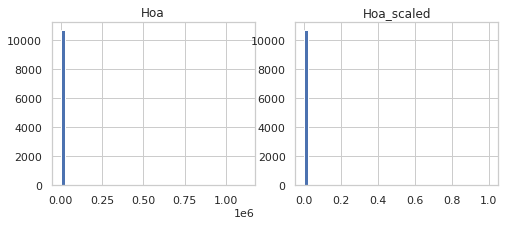

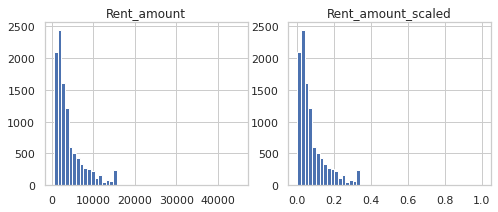

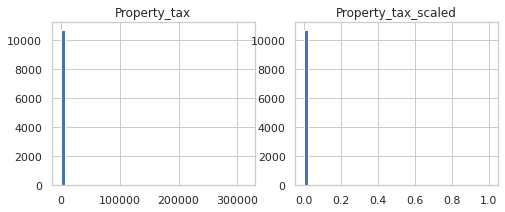

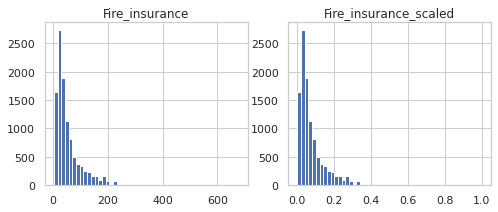

In [37]:
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(df[col], 50)
    ax[1].hist(df[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

# 4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [38]:
corr_cols_1 = scale_cols + ['Total']
corr_cols_1

['City',
 'Area',
 'Rooms',
 'Bathroom',
 'Parking_spaces',
 'Animal',
 'Furniture',
 'Hoa',
 'Rent_amount',
 'Property_tax',
 'Fire_insurance',
 'Total']

In [39]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Total']
corr_cols_2

['City_scaled',
 'Area_scaled',
 'Rooms_scaled',
 'Bathroom_scaled',
 'Parking_spaces_scaled',
 'Animal_scaled',
 'Furniture_scaled',
 'Hoa_scaled',
 'Rent_amount_scaled',
 'Property_tax_scaled',
 'Fire_insurance_scaled',
 'Total']

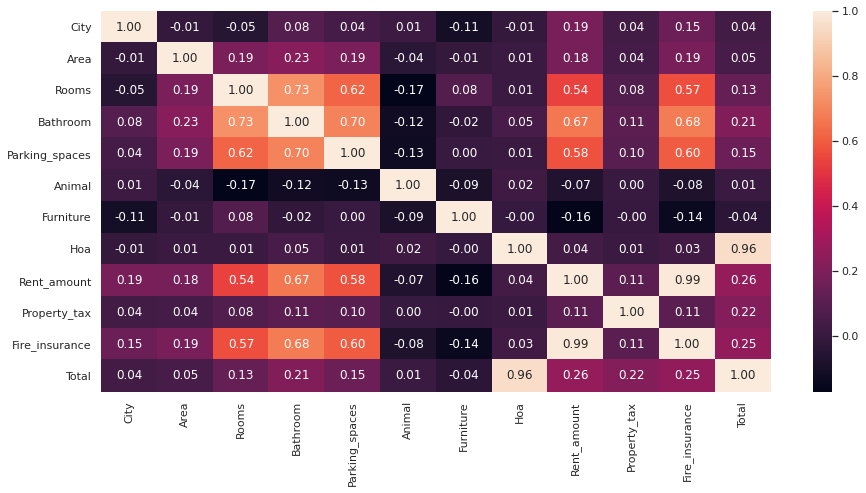

In [40]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df[corr_cols_1].corr(), annot=True, fmt='.2f')

Убедимся в том, что масштабирование не повлияло на корреляционную матрицу

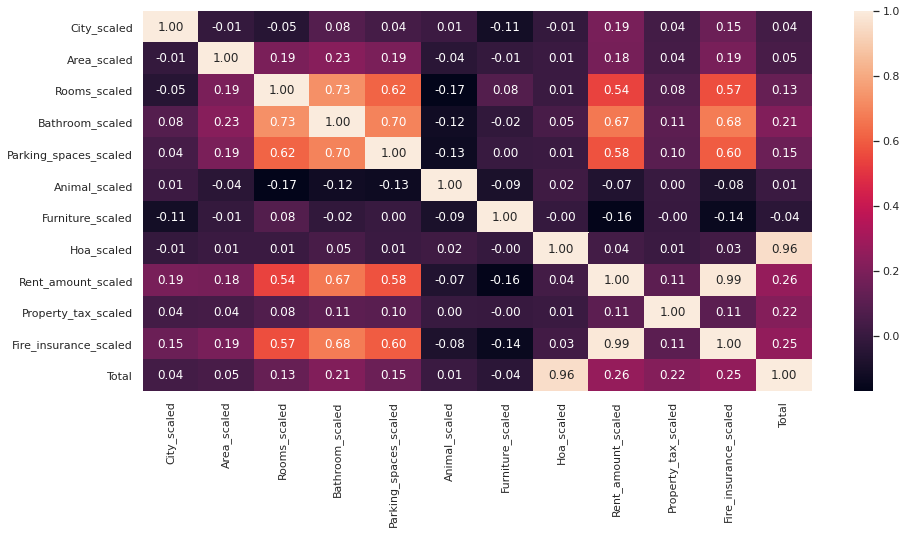

In [41]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df[corr_cols_2].corr(), annot=True, fmt='.2f')

На основе корреляционной матрицы можно сделать следующие выводы:

Корреляционные матрицы для исходных и масштабированных данных совпадают.
Целевой признак регрессии "Total_(R)" наиболее сильно коррелирует с "Hoa_(R)" (0,96). Этот признак обязательно следует оставить в модели регрессии.

Признаки "Rent_amount_(R)" и "Fire_insurance_(R)" имеют корреляцию, близкую по модулю к 1, поэтому будем использовать признак "Rent_amount_(R)", так как он лучше чем "Fire_insurance_(R)" коррелирует и с целевым признаком регрессии.

Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения. 

# 5. Выбор метрик для последующей оценки качества моделей.

## Метрики для решения задачи регрессии

В качестве метрик для решения задачи регрессии будем использовать:
1. Mean absolute error - средняя абсолютная ошибка

![alt text](https://sun9-47.userapi.com/4UfAVCboQ9aBuqVszxXVNCx893mEOSnluSZPkw/xtLbD-CJsWI.jpg)

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции mean_absolute_error.
2. Mean squared error - средняя квадратичная ошибка

![alt text](https://sun9-61.userapi.com/1rHIwXhj5uvaC0bcful5tVB27sa_uWDGVJrdmA/MBKGOSCOIl0.jpg)

Вычисляется с помощью функции mean_squared_error.
3. Метрика R2 или коэффициент детерминации

![alt text](https://sun9-60.userapi.com/TmC6gnaQ0HbfVYtabfW4uNZHUtky_k9bh401kQ/1OgI-bUcPyE.jpg)

Вычисляется с помощью функции r2_score.


## Сохранение и визуализация метрик

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [0]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

# 6. Выбор наиболее подходящих моделей для решения задачи регрессии.¶

Для задачи регрессии будем использовать следующие модели:

1. Линейная регрессия
2. Метод ближайших соседей
3. Машина опорных векторов
4. Решающее дерево
5. Случайный лес
6. CatBoost

# 7. Формирование обучающей и тестовой выборок на основе исходного набора данных.

## Объявление вектора объектов и целевой переменной

In [0]:
X = df.drop([ 
 'City', 
 'Animal',
 'Furniture',
 'Area',
 'Rooms',
 'Bathroom',
 'Parking_spaces',
 'Hoa',
 'Rent_amount',
 'Property_tax',
 'Fire_insurance',
 'Total',
 'Fire_insurance_scaled'], axis=1)
y = df['Total']

In [44]:
X.columns

Index(['City_scaled', 'Area_scaled', 'Rooms_scaled', 'Bathroom_scaled',
       'Parking_spaces_scaled', 'Animal_scaled', 'Furniture_scaled',
       'Hoa_scaled', 'Rent_amount_scaled', 'Property_tax_scaled'],
      dtype='object')

In [45]:
y.head


<bound method NDFrame.head of 0         5618
1         7973
2         3841
3         1421
4          836
         ...  
10687     1926
10688    19260
10689     7390
10690    14020
10691     1587
Name: Total, Length: 10692, dtype: int64>

## Разделение данных на отдельные тренировочные и тестовые наборы

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((7484, 10), (3208, 10), (7484,), (3208,))

Проверим соответствие столбцов

In [47]:
X_train.columns

Index(['City_scaled', 'Area_scaled', 'Rooms_scaled', 'Bathroom_scaled',
       'Parking_spaces_scaled', 'Animal_scaled', 'Furniture_scaled',
       'Hoa_scaled', 'Rent_amount_scaled', 'Property_tax_scaled'],
      dtype='object')

In [48]:
X_test.columns

Index(['City_scaled', 'Area_scaled', 'Rooms_scaled', 'Bathroom_scaled',
       'Parking_spaces_scaled', 'Animal_scaled', 'Furniture_scaled',
       'Hoa_scaled', 'Rent_amount_scaled', 'Property_tax_scaled'],
      dtype='object')

# 8. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [0]:
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'CB':CatBoostRegressor(loss_function='MAE')}

In [0]:
regrMetricLogger = MetricLogger()

In [0]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [74]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=5.034, MSE=738.267, R2=1.0
*****************************************************
*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

MAE=998.533, MSE=32974807.851, R2=0.36
*****************************************************
*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE=3081.092, MSE=53191716.355, R2=-0.032
*****************************************************
*****************************************************
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      ma

# 9. Подбор гиперпараметров для выбранных моделей.

Подберем гиперпараметры с помощью GridSearchCV для двух моделей: KNeighborsRegressor, DecisionTreeRegressor

1. Для KNeighborsRegressor

In [75]:
n_range = np.array(range(1,10,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}]

In [76]:

regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [77]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [78]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 2}

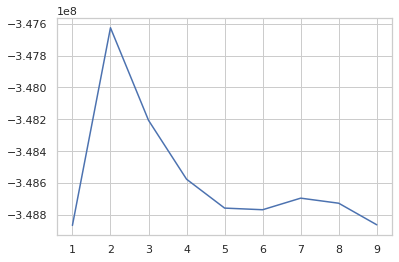

In [79]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

2. Для DecisionTreeRegressor

In [80]:
regr_gs_2= GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring='neg_mean_squared_error', cv=5)

regr_gs_2.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'min_samples_split': range(2, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [81]:
regr_gs_2.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [82]:
regr_gs_2.best_params_

{'min_samples_split': 2}

# 10. Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

In [0]:
regr_models_grid = {'KNN_2':regr_gs.best_estimator_}

In [86]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

MAE=1008.89, MSE=33094366.171, R2=0.358
*****************************************************


In [0]:
regr_models_grid_2 = {'Tree_2':regr_gs_2.best_estimator_}

In [88]:
for model_name, model in regr_models_grid_2.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

MAE=253.996, MSE=30977656.899, R2=0.399
*****************************************************


# 11. Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания.

In [89]:
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

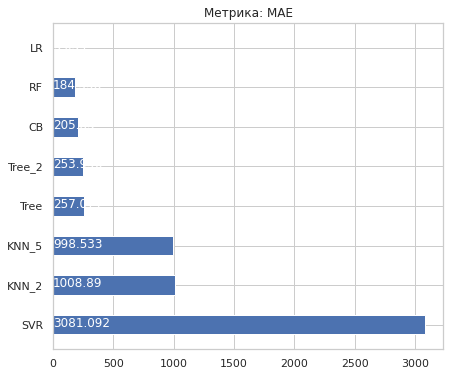

In [90]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

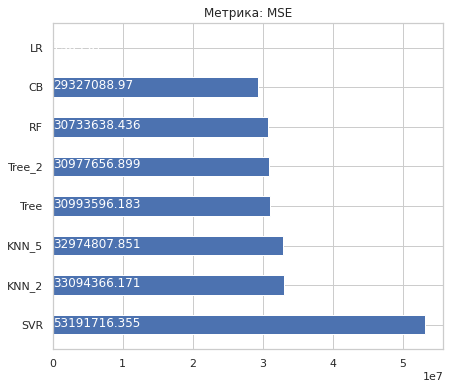

In [91]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

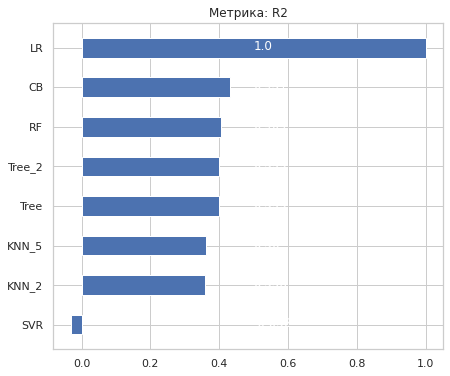

In [92]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

Вывод: в данном проекте лучшей оказалась модель на основе линейной регресии, далее с большим отрывом идет модель CatBoostс и случайного леса.